# Reading and Analyzing COMTRADE Files According to IEEE C37.111 Standard 

--- 

## Introduction 
**COMTARADE** (Commom Format for Transient Data Exchange for Power System)
> COMTRADE is a standard format for recording power system disterbance data such as faults, switching, or voltage sags. A typical COMTRADE dataset consists of: 
> - `.cfg` - Configuration file 
> - `.dat` - Recorded data file 

> Reference standard:
> - IEEE C37.111-1999 
> - IEEE C37.111-2013 (supports XML and binary formats) 

In [37]:
import numpy as np
import pandas as pd 
from comtrade import Comtrade 
import matplotlib.pyplot as plt 
import os 
from datetime import timedelta
from scipy.ndimage import uniform_filter1d 
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

In [38]:
# Magic command 
%matplotlib inline 

#### ***File Raw Data (COMTRADE)***

In [39]:
Tk().withdraw()
cfg_file = askopenfilename(title="Select .cfg file", filetypes=[("CFG files", "*.cfg")])
dat_file = askopenfilename(title="Select .dat file", filetypes=[("DAT files", "*.dat")])

print("✅ Selected CFG:", cfg_file)
print("✅ Selected DAT:", dat_file)

✅ Selected CFG: /Users/sarawinbuakaew/proj_readdr/comtrade_file/DR11012025/AA1E1Q01A1_DR850_20250111094636.cfg
✅ Selected DAT: /Users/sarawinbuakaew/proj_readdr/comtrade_file/DR11012025/AA1E1Q01A1_DR850_20250111094636.dat


#### ***Function Loading File COMTADE***

In [40]:
def load_comtrade(cfg, dat):
    rec = Comtrade() 
    rec.load(cfg, dat) 
    df = pd.DataFrame({ 
        rec.analog_channel_ids[i]:
        rec.analog[i] for  i in range(rec.analog_count)})
    
    df['time_s'] = rec.time
    return rec, df 

#### ***Process Analyzed***

In [41]:
rec, df = load_comtrade(cfg_file, dat_file)

trigger_time = rec.trigger_time 
trigger_datetime = rec.start_timestamp + timedelta(seconds=rec.trigger_time)
rec.trigger_timestamp
date = trigger_datetime.strftime('%Y-%m-%d %H:%M:%S %p')

v_base = 115000 / np.sqrt(3) 
cycle_duration_sec = 1 / 50 

logic = True

print(f"Fault occurred at: {date}")
print("Number of Sample : ", len(rec.analog[0]))
print("Number of Analog channel : ", len(rec.analog))
print("Number of Digital channel :", len(rec.digital))
print("Sampling rate :", rec.cfg.sample_rates[0][0], "Hz")
print("Trigger time = {} s".format(trigger_time))

df

Fault occurred at: 2025-01-11 09:46:36 AM
Number of Sample :  1240
Number of Analog channel :  9
Number of Digital channel : 47
Sampling rate : 1000.0 Hz
Trigger time = 0.499596 s


/Users/sarawinbuakaew/proj_readdr/drcomtrade/lib/python3.13/site-packages/comtrade.py:737: FutureWarning: digital is deprecated, use status instead.
  warnings.warn(FutureWarning("digital is deprecated, use status instead."))


,IL1,IL2,IL3,I0,UL1,UL2,UL3,U0,U-BUS-12,time_s
0,-0.242746,-3.172312,5.980096,-0.209964,-18209.445312,90353.601562,-72257.023438,-37.885708,156530.015625,0.000
1,-0.138712,-3.337463,6.125719,-0.284978,-44810.519531,96741.789062,-51959.171875,-9.931205,167690.546875,0.001
2,0.857547,-3.746191,3.528713,-0.201679,-68688.601562,94085.726562,-25233.318359,53.334248,163122.531250,0.002
3,2.954688,-3.480622,2.402081,-0.532486,-86503.890625,79121.656250,7539.966797,53.334248,137168.656250,0.003
4,4.724444,-4.321315,1.993974,0.270722,-95467.195312,59281.210938,36245.953125,20.230232,102890.617188,0.004
...,...,...,...,...,...,...,...,...,...,...
1235,-3.003472,2.366889,0.902036,1.112967,89630.070312,-20551.886719,-69212.492188,-44.874332,-35691.082031,1.235
1236,-2.969970,1.685122,2.207614,0.700428,73800.609375,11866.321289,-85853.343750,-61.426342,20491.798828,1.236
1237,-4.267164,1.340711,1.989409,0.567717,53418.785156,39544.523438,-93250.601562,-96.001648,68448.164062,1.237
1238,-1.748009,-0.462672,1.898566,0.003732,27744.429688,64397.691406,-92430.000000,-94.898178,111538.492188,1.238


In [42]:
# Times
time = np.array(rec.time)

# Voltage 
ul1 = np.array(rec.analog[4]) 
ul2 = np.array(rec.analog[5]) 
ul3 = np.array(rec.analog[6])

# Current 
il1 = np.array(rec.analog[0])
il2 = np.array(rec.analog[1])
il3 = np.array(rec.analog[2])

# V0 & I0 (Zero-Sq)
v0 = np.array(rec.analog[7]) 
i0 = np.array(rec.analog[3])

In [43]:
# Root Mean Sqr (RMS) 
window_size = int(1000 * cycle_duration_sec)
v1_rms = np.sqrt(uniform_filter1d(ul1**2, size=window_size))
v2_rms = np.sqrt(uniform_filter1d(ul2**2, size=window_size))
v3_rms = np.sqrt(uniform_filter1d(ul3**2, size=window_size))

In [44]:
threshold = 1500 # V
fault_mask = np.abs(v0) > threshold

# Find index Start-to-End Fault
fault_start_index = np.argmax(fault_mask)
fault_end_index = len(fault_mask) - np.argmax(fault_mask[::-1]) - 1

# Calculate Time 
fault_start_time = time[fault_start_index]
fault_end_time = time[fault_end_index]
fault_duration = fault_end_time - fault_start_time

print(f"Fault Duration: {fault_duration*1000:.2f} ms")
print(f"Start: {fault_start_time:.3f} s | End: {fault_end_time:.3f} s")

Fault Duration: 252.00 ms
Start: 0.475 s | End: 0.727 s


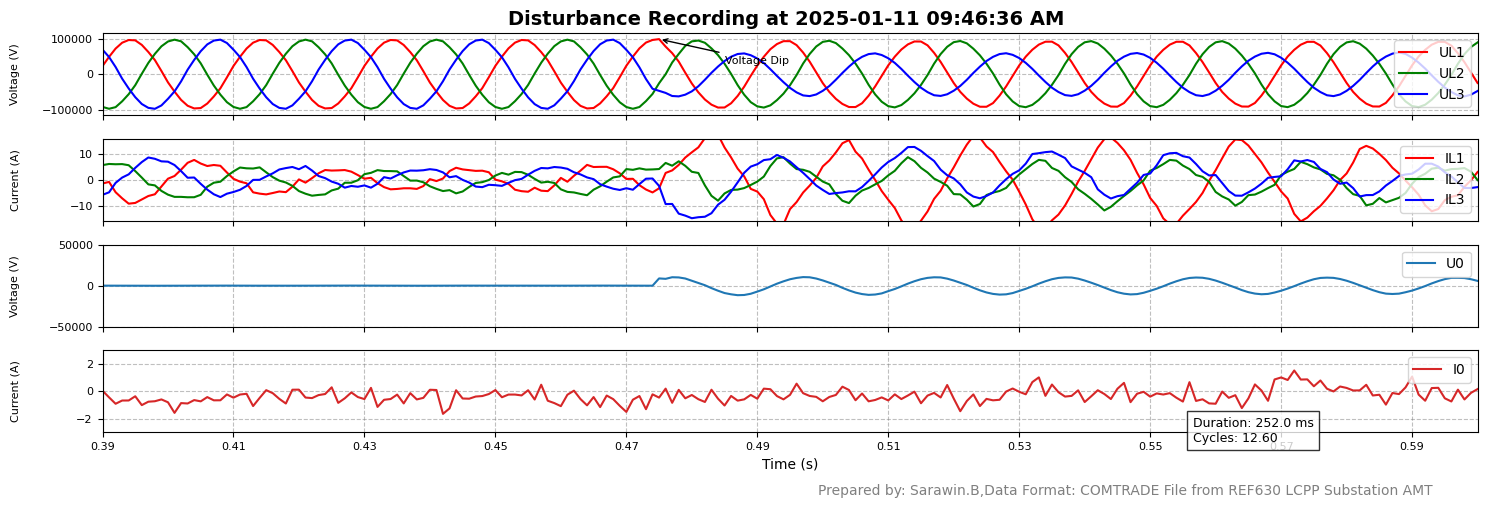

In [45]:
fig, axes = plt.subplots(4, 1, figsize=(15, 5), sharex=logic)
# Voltage Side 
axes[0].set_title("Disturbance Recording at {} ".format(date), 
                  fontsize=14, 
                  fontweight='bold',
                  )



# for ax in axes:
#     ax.axvspan(fault_start_time, fault_end_time, color='yellow', alpha=0.3)
#     ax.axvline(fault_start_time, color='orange', linestyle='--')
#     ax.axvline(fault_end_time, color='red', linestyle='--')
axes[0].annotate('Voltage Dip',
                 xy=(fault_start_time, ul1[np.argmin(abs(time - fault_start_time))]),
                 xytext=(fault_start_time + 0.01, 30000),
                 arrowprops=dict(arrowstyle="->", color='black'),
                 fontsize=8)

plt.tight_layout(pad=1.5)



axes[0].set_ylim(min(ul1.min(), ul2.min(), ul3.min()) * 1.2,
                 max(ul1.max(), ul2.max(), ul3.max()) * 1.2)

axes[0].plot(time, ul1, label=rec.analog_channel_ids[4], c='r')
axes[0].plot(time, ul2, label=rec.analog_channel_ids[5], c='g') 
axes[0].plot(time, ul3, label=rec.analog_channel_ids[6], c='b') 
axes[0].set_ylabel("Voltage (V)", fontsize=8)
axes[0].set_ylim(-115000, 115000)

# axes[0].annotate('Voltage Dip',
#                  xy=(fault_start_time, ul1[np.argmin(abs(time - fault_start_time))]),
#                  xytext=(fault_start_time + 0.01, 0),
#                  arrowprops=dict(arrowstyle="->", color='black'),
#                  fontsize=8)




axes[1].plot(time, il1, label=rec.analog_channel_ids[0], c='r')
axes[1].plot(time, il2, label=rec.analog_channel_ids[1], c='g')
axes[1].plot(time, il3, label=rec.analog_channel_ids[2], c='b')
axes[1].set_ylabel("Current (A)", fontsize=8)
axes[1].set_ylim(-16, 16)


axes[2].plot(time, v0, label=rec.analog_channel_ids[7], c='#1f77b4') 
axes[2].set_ylabel("Voltage (V)", fontsize=8)
axes[2].set_ylim(-50000, 50000)


axes[3].plot(time, i0, label=rec.analog_channel_ids[3], c='#d62728')
axes[3].set_ylabel("Current (A)", fontsize=8)
axes[3].set_ylim(-3, 3)
axes[3].set_xlabel('Times (s)')
axes[3].set_xlabel("Time (s)", fontsize=10)

# for ax in axes:
#     ax.set_ylabel(ax.get_ylabel(), fontsize=10)



axes[0].grid(logic, linestyle='--', c='gray', alpha=0.5)
axes[1].grid(logic, linestyle='--', c='gray', alpha=0.5)
axes[2].grid(logic, linestyle='--', c='gray', alpha=0.5)
axes[3].grid(logic, linestyle='--', c='gray', alpha=0.5)


axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')
axes[3].legend(loc='upper right')


axes[0].set_xlim(0.39, 0.60)
axes[0].set_xticks(np.arange(0.39,
                             0.60,
                             0.02))

for ax in axes:
    ax.tick_params(axis='x', rotation=0, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

fig.text(0.8, 0.1, f"Duration: {fault_duration*1000:.1f} ms\nCycles: {fault_duration*50:.2f}",
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=9, va='bottom')


for ax in axes:
    ax.yaxis.set_label_coords(-0.06, 0.5)

plt.text(0.55, -0.0001,
         "Prepared by: Sarawin.B"
         ",Data Format: COMTRADE File from REF630 LCPP Substation AMT",
         fontsize=10,
         color='gray',
         transform=fig.transFigure)



plt.savefig(f'Disturbance Analyzer at {date}.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [46]:
# Thresholds
v_threshold = 0.8 * v_base  # such as  80 % for 66.4 kV ≈ 53,000 V
i_threshold = 2.0  # A, adjust systems

# inspection phase voltage under 
faulty_phases_voltage = []
if np.min(v1_rms) < v_threshold:
    faulty_phases_voltage.append("Phase A")
if np.min(v2_rms) < v_threshold:
    faulty_phases_voltage.append("Phase B")
if np.min(v3_rms) < v_threshold:
    faulty_phases_voltage.append("Phase C")

# inspection phase inrush (such as > 2x normal)
faulty_phases_current = []
if np.max(il1) > i_threshold:
    faulty_phases_current.append("Phase A")
if np.max(il2) > i_threshold:
    faulty_phases_current.append("Phase B")
if np.max(il3) > i_threshold:
    faulty_phases_current.append("Phase C")

# Display
print("🔍 Fault Detected on Phases (Under-Voltage):", faulty_phases_voltage)
print("⚡️ Fault Detected on Phases (Overcurrent):", faulty_phases_current)

# Sunmarized automate
from collections import Counter
summary = Counter(faulty_phases_voltage + faulty_phases_current)
detected_faults = [phase for phase, count in summary.items() if count > 1]

print("✅ Final Fault Phase :", detected_faults if detected_faults else "Unable to determine with high confidence")

🔍 Fault Detected on Phases (Under-Voltage): ['Phase C']
⚡️ Fault Detected on Phases (Overcurrent): ['Phase A', 'Phase B', 'Phase C']
✅ Final Fault Phase : ['Phase C']


In [47]:
# Cutting Fault duration
v1_fault = v1_rms[fault_start_index:fault_end_index]
v2_fault = v2_rms[fault_start_index:fault_end_index]
v3_fault = v3_rms[fault_start_index:fault_end_index]

# Find minimum voltage of Phase Fault
v1_min = np.min(np.abs(v1_fault))
v2_min = np.min(np.abs(v2_fault))
v3_min = np.min(np.abs(v3_fault))

# Find minimum min phase (for calculation Per Unit / Sag%)
v_fault_min = min(v1_min, v2_min, v3_min)


v_pu = v_fault_min / v_base
v_sag = (1 - v_pu) * 100

print(f"="*40)
print("Substation 115/22 kV @Amita Technology (Thailand)")
print(f"="*40)
print(f"Date : {date}")
print(f"Phase Fault : {detected_faults if detected_faults else 'Unable to determine with high confidence'}")
print(f"Under Voltage : {v_fault_min:.2f} V")
print(f"Votlage p.u. : {v_pu:.2f} pu.")
print("Voltage Sag : {:.2f} %".format(v_sag))
cycles = fault_duration * 50  # เพราะ 1 วินาทีมี 50 cycles ในระบบ 50Hz
print(f"Fault Duration: {fault_duration*1000:.2f} ms ({cycles:.2f} cycles)")


print(f"-"*40)

Substation 115/22 kV @Amita Technology (Thailand)
Date : 2025-01-11 09:46:36 AM
Phase Fault : ['Phase C']
Under Voltage : 42036.17 V
Votlage p.u. : 0.63 pu.
Voltage Sag : 36.69 %
Fault Duration: 252.00 ms (12.60 cycles)
----------------------------------------


#### **Export to CSV File**

In [ ]:
date = trigger_datetime.strftime('%d-%m-%Y')
result = pd.DataFrame({
    
    'Event Date' : [(date)],
    'Confirmed Faults'      : [", ".join(detected_faults) if detected_faults else "Undetermind"],
    'Fault Strat time (s)'  : [round(float(fault_start_time),2)],
    'Fault End time (s)'    : [round(float(fault_end_time), 2)],
    'Fault Duration (ms)'   : [round(float(fault_duration * 1000), 2)], 
    "Voltage Sag "          : [round(float(v_sag), 2)],
    "Voltage p.u."          : [round(float(v_pu), 2)],
 })

file_name = "/Users/sarawinbuakaew/substation-disturbance-report/results/fault_analysis_results.csv"
file_exists = os.path.isfile(file_name)
result.to_csv(file_name, mode='a', header=not file_exists, index=False) 
print("Export to CSV. Successed ✅")

Export to CSV. Successed ✅


: 